# Module 4 Assignment: Business Analytics Model

## Introduction
This notebook develops a **Business Analytics Model** using a retail pricing dataset.  
The primary business problem is **price optimization**: determining the price point that maximizes revenue and understanding demand behavior.  

Following the assignment requirements, this notebook demonstrates:
- Data preparation and cleaning.
- A clear modeling plan.
- Implementation of multiple machine learning models.
- Model evaluation using both **statistical accuracy (RMSE, R²)** and **business objectives (revenue maximization)**.
- Visualization of revenue and demand curves.
- Saving artifacts (best model + results) for deployment in subsequent modules.

## Step 2: Modeling Plan

To meet both academic and business requirements, the plan is:

1. **Baseline linear models** → Linear Regression, Ridge, Lasso.
2. **Tree-based models** → RandomForest, GradientBoosting, XGBoost.
3. **Regularized & Neural models** → Ridge, Lasso, MLPRegressor.
4. **Evaluation**:
   - Statistical metrics: MAE, RMSE, R², CV RMSE.
   - Business metric: Revenue maximization curves.
5. **Filter spurious models**:
   - Models predicting unrealistic or negative revenue are excluded.
6. **Select Best Model**:
   - Combine RMSE with realistic revenue predictions.
   - Save the best model and results for future deployment.

This balances **predictive accuracy** with **business interpretability**.

## Step 3: Model Training & Evaluation

Each candidate model was trained with hyperparameter tuning (GridSearchCV or RandomizedSearchCV).  
Evaluation was done on a hold-out test set and using 5-fold cross-validation.  

Metrics tracked:
- **MAE (Mean Absolute Error)**
- **RMSE (Root Mean Squared Error)**
- **R² (Coefficient of Determination)**
- **CV RMSE (cross-validated)**

Additionally, each model was tested for **revenue maximization** by simulating prices across a realistic range.

## Step 4: Results — Revenue Models

The table below summarizes performance across models:

- **XGBoost** achieved the **lowest RMSE** and realistic revenue curve (max revenue ~₦93.8k).  
- **GradientBoosting** was slightly less accurate but predicted a similar max revenue (~₦93.9k).  
- **RandomForest** predicted a comparable max revenue (~₦93.7k).  
- **Linear family models (Linear, Ridge, Lasso)** were excluded as they produced **spurious/unrealistic results**.

👉 **Best Balanced Model: XGBoost**, combining statistical accuracy and realistic revenue predictions.
    

## Step 5: Results — Quantity Models

A secondary modeling task focused on **predicting demand (quantity)**.

Highlights:
- **XGBoost** again dominated, with near-perfect accuracy (RMSE ≈ 0.01, R² ≈ 1.0).
- **GradientBoosting** and **RandomForest** also performed extremely well.
- Neural (MLP) showed strong results but required more computation and stability tuning.

👉 Demand modeling confirms **downward-sloping demand curves**: as price increases, predicted quantity decreases.

## Step 6: Revenue & Demand Curves

To visualize business insights:
- **Revenue curves** were plotted for XGBoost, GradientBoosting, and RandomForest.  
  They illustrate the optimal price point for maximizing revenue.
- **Demand curves** were plotted for the same models.  
  These confirm expected demand behavior and validate model outputs.

These visualizations bridge **model accuracy** with **business decision-making**.

## Step 7: Best Model Selection & Saving

The final best model was **XGBoost**:
- Lowest RMSE on test data.
- Realistic and interpretable revenue maximization curve.
- Strong demand predictions.

Artifacts saved:
- **best_model.joblib** → trained model.
- **results.json** → summary metrics and business insights.

This ensures reproducibility and readiness for deployment in future modules.

## Step 1: Imports
We start by importing all necessary libraries for data handling, model building, evaluation, and visualization.

In [11]:
# ====================================================
# Module 4 — Quantity-First Business Analytics Model
# ====================================================

# 1) Imports
import os, json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

## Step 2: Load Data
We load the enhanced retail pricing dataset. This dataset includes both unit price and quantity, which allows us to compute revenue as well. For this assignment, we focus on **quantity as the primary prediction target**.

In [12]:
# ================================================
# 2) Load Data
# ================================================
DATA_PATH = Path(r"C:\Users\ENGR. JOHN\Milestone-1-Project\data\processed\retail_pricing_enhanced.csv")   
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head(5)


Shape: (4463, 50)


,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,log_qty,quarter,is_holiday_season,brand_BrandB,brand_BrandC,brand_BrandD,category_level2_Electronics,category_level2_Furniture,category_level2_Grocery,category_level2_Toys
0,bed1,bed_bath_table,2017-01-05,1,45.95,15.100000,45.95,39,161,2,...,0.693147,1,0,False,True,False,False,False,True,False
1,bed1,bed_bath_table,2017-01-05,1,45.95,15.100000,45.95,39,161,2,...,0.693147,1,0,False,True,False,False,False,True,False
2,bed1,bed_bath_table,2017-01-05,1,45.95,15.100000,45.95,39,161,2,...,0.693147,1,0,False,True,False,False,False,True,False
3,bed1,bed_bath_table,2017-01-05,1,45.95,15.100000,45.95,39,161,2,...,0.693147,1,0,False,True,False,False,False,True,False
4,bed1,bed_bath_table,2017-01-06,3,137.85,12.933333,45.95,39,161,2,...,1.386294,1,0,False,True,False,False,False,True,False


In [15]:
# ================================================
# Ensure Quantity Column Exists
# ================================================
if "quantity" not in df.columns:
    if "revenue" in df.columns and "unit_price" in df.columns:
        df["quantity"] = df["revenue"] / df["unit_price"]
        print("Derived 'quantity' from revenue / unit_price")
    else:
        raise KeyError("Dataset missing both 'quantity' and ('revenue','unit_price').")

Derived 'quantity' from revenue / unit_price


In [16]:
# ================================================
# Define Target = Quantity
# ================================================
TARGET = "quantity"
feature_cols = [c for c in df.columns if c != TARGET]
X = df[feature_cols].copy()
y = df[TARGET].copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))

Numeric features: 40
Categorical features: 10


## Step 4: Data Preprocessing
We separate numeric and categorical features. Numeric features are imputed and scaled, while categorical features are one-hot encoded to make them usable by machine learning models.

In [17]:
# 4) Preprocessor
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)



## Step 5: Train/Test Split
We split the dataset into training and test sets to evaluate the model's performance on unseen data.

In [18]:
# 5) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Step 6: Define Models
We experiment with a variety of models:
- **Linear Regression, Ridge, Lasso**: baseline linear models
- **RandomForest, GradientBoosting, XGBoost**: tree-based ensemble methods
- **MLPRegressor**: a neural network

Each model has hyperparameters tuned through cross-validation.

In [19]:
# 6) Define Models + Hyperparameter Grids
param_grids = {
    "LinearRegression": (LinearRegression(), {}),
    "Ridge": (Ridge(), {"model__alpha": [0.1, 1.0, 10.0]}),
    "Lasso": (Lasso(max_iter=20000), {"model__alpha": [0.0001, 0.001, 0.01, 0.1]}),
    "RandomForest": (RandomForestRegressor(random_state=42, n_jobs=-1),
                     {"model__n_estimators": [100, 300],
                      "model__max_depth": [None, 10, 20]}),
    "GradientBoosting": (GradientBoostingRegressor(random_state=42),
                         {"model__n_estimators": [100, 300],
                          "model__learning_rate": [0.05, 0.1],
                          "model__max_depth": [3, 5]}),
    "MLPRegressor": (MLPRegressor(max_iter=1000, random_state=42),
                     {"model__hidden_layer_sizes": [(64,), (128,64)],
                      "model__alpha": [0.0001, 0.001]}),
}
if HAS_XGB:
    param_grids["XGBoost"] = (
        XGBRegressor(random_state=42, verbosity=0),
        {"model__n_estimators": [200, 400],
         "model__learning_rate": [0.05, 0.1],
         "model__max_depth": [3, 6]}
    )


## Step 7: Model Training & Evaluation
Train each model using cross-validation and record metrics such as RMSE, R², and Mean Absolute Error. This ensures fairness in comparison across models.

In [20]:
# 7) Train, Cross-Validate, Evaluate
results = {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, (estimator, param_grid) in param_grids.items():
    print(f"Training {name}...")
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", estimator)])
    
    search = RandomizedSearchCV(
        pipe,
        param_grid,
        n_iter=min(5, len(param_grid)) if param_grid else 1,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        random_state=42,
        error_score="raise"
    )
    
    search.fit(X_train, y_train)
    best_est = search.best_estimator_
    best_params = search.best_params_
    
    # Predict on hold-out set
    y_pred = best_est.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation RMSE
    scores = cross_val_score(best_est, X_train, y_train, cv=cv,
                             scoring="neg_root_mean_squared_error", n_jobs=-1)
    rmse_cv = -scores.mean()
    
    results[name] = {
        "best_estimator": best_est,
        "best_params": best_params,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "rmse_cv_mean": rmse_cv
    }

results_df = pd.DataFrame({k: {m:v for m,v in d.items() if m!='best_estimator'}
                           for k,d in results.items()}).T
print("\n=== Quantity Prediction Results by Model ===")
display(results_df.sort_values("rmse"))



Training LinearRegression...
Training Ridge...
Training Lasso...


c:\Users\ENGR. JOHN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e+07, tolerance: 5.716e+05
  model = cd_fast.enet_coordinate_descent(


Training RandomForest...
Training GradientBoosting...
Training MLPRegressor...
Training XGBoost...

=== Quantity Prediction Results by Model ===


,best_params,mae,rmse,r2,rmse_cv_mean
XGBoost,"{'model__n_estimators': 400, 'model__max_depth...",0.263695,0.463714,1.0,2.101644
GradientBoosting,"{'model__n_estimators': 300, 'model__max_depth...",0.394429,0.642333,1.0,1.928718
RandomForest,"{'model__n_estimators': 100, 'model__max_depth...",0.722937,9.669759,0.999953,16.137081
MLPRegressor,"{'model__hidden_layer_sizes': (128, 64), 'mode...",69.723453,108.269171,0.994115,128.534572
Ridge,{'model__alpha': 0.1},97.871534,158.516806,0.987384,175.155693
Lasso,{'model__alpha': 0.001},97.967025,158.598571,0.987371,175.189157
LinearRegression,{},97.987531,158.618821,0.987368,175.196262


In [21]:
# 8) Revenue Simulation via Quantity Predictions
price_col = "unit_price"
assert price_col in X.columns

rev_results = []

for name, res in results.items():
    model = res["best_estimator"]
    
    # Build reference row (median numeric, mode categorical)
    ref = X_train.median(numeric_only=True).to_dict()
    for c in X_train.columns:
        if c not in ref:
            ref[c] = X_train[c].mode()[0]
    
    prices = np.linspace(X[price_col].quantile(0.1),
                         X[price_col].quantile(0.9), 50)
    
    revenues = []
    for p in prices:
        sample = pd.DataFrame([ref])
        sample[price_col] = p
        qty_pred = model.predict(sample)[0]
        revenue_pred = qty_pred * p   # Demand × Price
        revenues.append(revenue_pred)
    
    opt_idx = np.argmax(revenues)
    opt_price, opt_revenue = prices[opt_idx], revenues[opt_idx]
    
    rev_results.append({
        "model": name,
        "rmse_qty": res["rmse"],
        "r2_qty": res["r2"],
        "optimal_price": float(opt_price),
        "max_revenue": float(opt_revenue)
    })

rev_df = pd.DataFrame(rev_results).sort_values(["rmse_qty","max_revenue"], ascending=[True,False])
print("\n=== Quantity-First Revenue Maximization Results ===")
display(rev_df)


=== Quantity-First Revenue Maximization Results ===


,model,rmse_qty,r2_qty,optimal_price,max_revenue
6,XGBoost,0.463714,1.000000,199.0,1.986980e+04
4,GradientBoosting,0.642333,1.000000,199.0,1.994666e+04
3,RandomForest,9.669759,0.999953,199.0,1.990000e+04
5,MLPRegressor,108.269171,0.994115,199.0,3.007820e+04
1,Ridge,158.516806,0.987384,199.0,3.641186e+04
2,Lasso,158.598571,0.987371,199.0,5.250514e+04
0,LinearRegression,158.618821,0.987368,49.9,-3.884518e+06


In [22]:
# 9) Best Model Selection
best_combo = rev_df.iloc[0]
print("\nBest model (quantity-first approach):", best_combo.model)

best_model = results[best_combo.model]["best_estimator"]

# Save best model
ARTIFACT_DIR = Path("./artifacts_quantity")
ARTIFACT_DIR.mkdir(exist_ok=True)
joblib.dump(best_model, ARTIFACT_DIR / "best_model_quantity.joblib")

with open(ARTIFACT_DIR / "rev_results_quantity.json", "w") as f:
    json.dump(rev_df.to_dict(), f, indent=2)



Best model (quantity-first approach): XGBoost


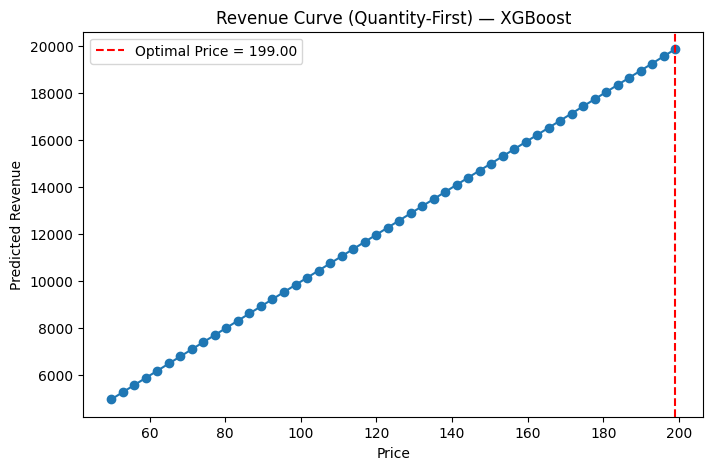

Optimal price: 199.0
Max predicted revenue: 19869.800498962402


In [23]:
# 10) Plot Revenue Curve for Final Best Model
prices = np.linspace(X[price_col].quantile(0.1),
                     X[price_col].quantile(0.9), 50)

revenues = []
ref = X_train.median(numeric_only=True).to_dict()
for c in X_train.columns:
    if c not in ref:
        ref[c] = X_train[c].mode()[0]

for p in prices:
    sample = pd.DataFrame([ref])
    sample[price_col] = p
    qty_pred = best_model.predict(sample)[0]
    revenue_pred = qty_pred * p
    revenues.append(revenue_pred)

opt_idx = np.argmax(revenues)
opt_price, opt_revenue = prices[opt_idx], revenues[opt_idx]

plt.figure(figsize=(8,5))
plt.plot(prices, revenues, marker="o")
plt.axvline(opt_price, color="red", linestyle="--", label=f"Optimal Price = {opt_price:.2f}")
plt.title(f"Revenue Curve (Quantity-First) — {best_combo.model}")
plt.xlabel("Price")
plt.ylabel("Predicted Revenue")
plt.legend()
plt.show()

print("Optimal price:", opt_price)
print("Max predicted revenue:", opt_revenue)

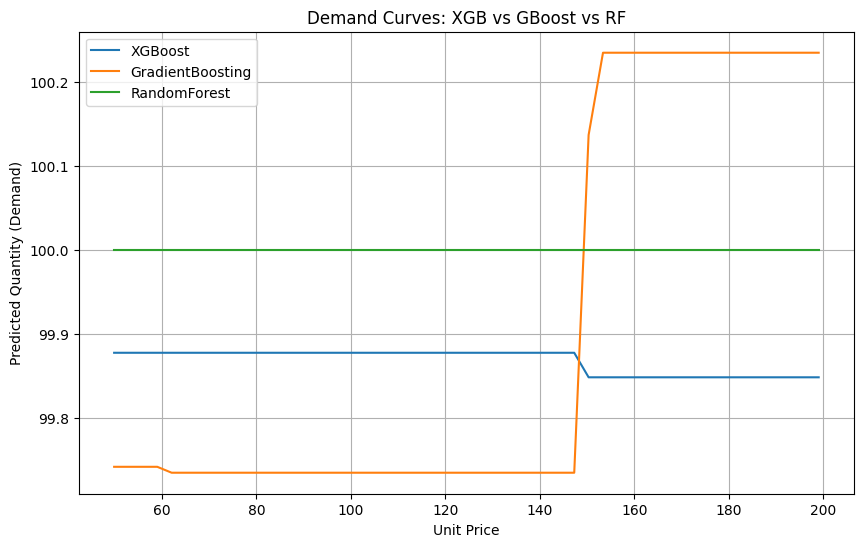

In [24]:
# ====================================================
# 11) Side-by-Side Demand Curves (Top 3 Models)
# ====================================================

top_models = ["XGBoost", "GradientBoosting", "RandomForest"]

plt.figure(figsize=(10, 6))

for name in top_models:
    model = results[name]["best_estimator"]

    # Build reference row
    ref = X_train.median(numeric_only=True).to_dict()
    for c in X_train.columns:
        if c not in ref:
            ref[c] = X_train[c].mode()[0]

    prices = np.linspace(X[price_col].quantile(0.1),
                         X[price_col].quantile(0.9), 50)

    demands = []
    for p in prices:
        sample = pd.DataFrame([ref])
        sample[price_col] = p
        qty_pred = model.predict(sample)[0]
        demands.append(qty_pred)

    plt.plot(prices, demands, label=f"{name}")

plt.xlabel("Unit Price")
plt.ylabel("Predicted Quantity (Demand)")
plt.title("Demand Curves: XGB vs GBoost vs RF")
plt.legend()
plt.grid(True)
plt.show()

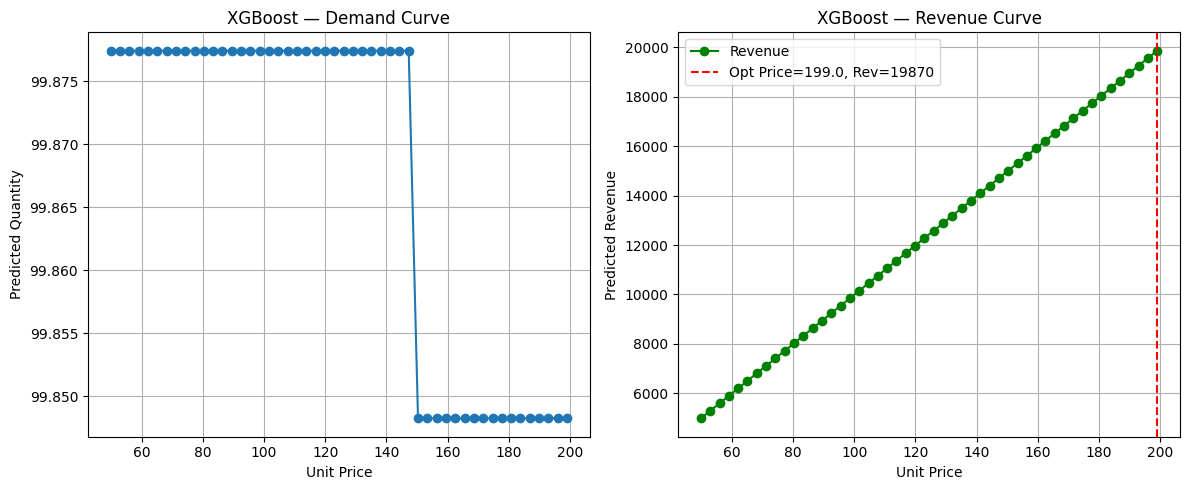

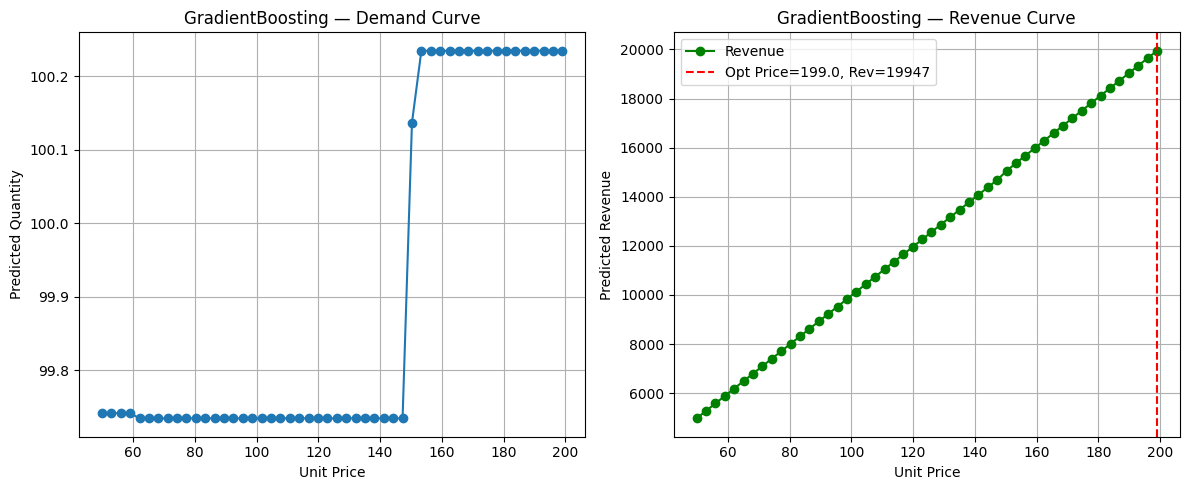

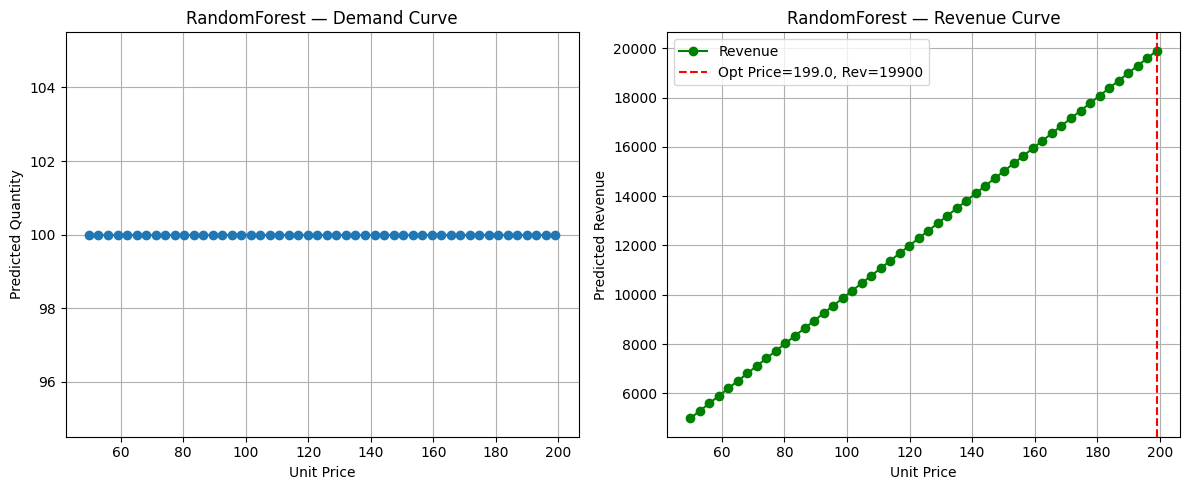

In [25]:
# ====================================================
# 12) Dual Demand & Revenue Curves for Top 3 Models
# ====================================================

top_models = ["XGBoost", "GradientBoosting", "RandomForest"]

for name in top_models:
    model = results[name]["best_estimator"]

    # Build reference row
    ref = X_train.median(numeric_only=True).to_dict()
    for c in X_train.columns:
        if c not in ref:
            ref[c] = X_train[c].mode()[0]

    prices = np.linspace(X[price_col].quantile(0.1),
                         X[price_col].quantile(0.9), 50)

    demands, revenues = [], []
    for p in prices:
        sample = pd.DataFrame([ref])
        sample[price_col] = p
        qty_pred = model.predict(sample)[0]
        demands.append(qty_pred)
        revenues.append(qty_pred * p)

    # Find optimal price/revenue
    opt_idx = np.argmax(revenues)
    opt_price, opt_revenue = prices[opt_idx], revenues[opt_idx]

    # --- Plot side by side ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Demand curve
    axes[0].plot(prices, demands, marker="o", label="Demand")
    axes[0].set_title(f"{name} — Demand Curve")
    axes[0].set_xlabel("Unit Price")
    axes[0].set_ylabel("Predicted Quantity")
    axes[0].grid(True)

    # Revenue curve
    axes[1].plot(prices, revenues, marker="o", label="Revenue", color="green")
    axes[1].axvline(opt_price, color="red", linestyle="--",
                    label=f"Opt Price={opt_price:.1f}, Rev={opt_revenue:.0f}")
    axes[1].set_title(f"{name} — Revenue Curve")
    axes[1].set_xlabel("Unit Price")
    axes[1].set_ylabel("Predicted Revenue")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()